### 멀티모달 임베딩 벡터 생성 (Multimodal Embedding Vector) 

1. 이미지 데이터 전처리 후 증강
2. 이미지 데이터 + Caption 데이터 결합하여 임베딩 벡터 생성
3. 벡터 시각화

### 이미지 데이터 전처리 후 증강

In [ ]:
import os
from PIL import Image
import torchvision.transforms as T
import cv2
import numpy as np

input_dir = r"C:\Users\mh\Desktop\swbootcamp\sandstone_최종_진짜"
output_dir = r"C:\Users\mh\Desktop\swbootcamp\sandstone_최종_진짜_증강"

os.makedirs(output_dir, exist_ok=True)

def preprocess_icon_image(pil_image, size=(224,224), pad_color=255):
    # PIL -> OpenCV 변환
    img = np.array(pil_image.convert("L"))  # 흑백 변환
    
    # 이진화 (역 이진화: 선은 검은색(0), 배경은 흰색(255))
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    
    # 노이즈 제거 (morphology open)
    kernel = np.ones((3,3), np.uint8)
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # 크기 조정 + 패딩 (비율 유지)
    h, w = clean.shape
    scale = min(size[0]/h, size[1]/w)
    nh, nw = int(h*scale), int(w*scale)
    resized = cv2.resize(clean, (nw, nh))
    top = (size[0] - nh) // 2
    bottom = size[0] - nh - top
    left = (size[1] - nw) // 2
    right = size[1] - nw - left
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_color)
    
    # OpenCV -> PIL 변환 및 RGB 변환
    pil_processed = Image.fromarray(padded).convert("RGB")
    return pil_processed

def augment_image(image):
    transform = T.Compose([
        T.RandomRotation(degrees=15),
        T.RandomResizedCrop(size=image.size[0], scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(p=0.5),
        T.ColorJitter(brightness=0.2, contrast=0.2),
    ])
    return transform(image)

print("증강 시작...")
for filename in os.listdir(input_dir):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)

        # 1) 원본 이미지도 알파채널 있으면 흰배경으로 변환
        if img.mode == 'RGBA':
            background = Image.new("RGBA", img.size, (255, 255, 255, 255))
            img = Image.alpha_composite(background, img).convert("RGB")
        else:
            img = img.convert("RGB")

        # 2) 원본 이미지 전처리 후 저장
        img_processed = preprocess_icon_image(img)
        img_processed.save(os.path.join(output_dir, filename))

        # 3) 전처리된 이미지 기반으로 증강 6장 생성
        for i in range(6):
            aug_img = augment_image(img_processed)
            save_name = os.path.splitext(filename)[0] + f"_aug{i+1}.png"
            aug_img.save(os.path.join(output_dir, save_name))

print("증강 완료!")


증강 시작...
증강 완료!


### 이미지 및 Caption 텍스트 데이터 CLIP 임베딩

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.preprocessing import normalize
import torch
import re

# 1) CLIP 모델 및 프로세서 불러오기
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# 2) 레퍼런스 이미지 임베딩 생성 함수
def extract_image_features(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        features = model.get_image_features(**inputs)
    features = features.cpu().numpy()
    return features[0]

# 3) 레퍼런스 이미지 폴더 경로
reference_dir = rf"C:\Users\mh\Desktop\swbootcamp\sandstone_최종_진짜_증강"

# 4) 메타데이터 CSV 경로 및 불러오기
csv_path = rf"C:\Users\mh\Desktop\swbootcamp\output_archive_processed_최종.csv"
df = pd.read_csv(csv_path, encoding="utf-8-sig")

# 확장자를 제거한 파일명을 키로 사용
df["key"] = df["input_file"].apply(lambda x: os.path.splitext(x)[0])

# 5) 레퍼런스 벡터와 레이블 저장용 리스트
reference_vectors = []
reference_labels = []

print("레퍼런스 이미지 + 텍스트(우선순위1) 임베딩 추출 중...")

for filename in os.listdir(reference_dir):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        key = os.path.splitext(filename)[0]
        
        # 증강된 파일명 처리: '_aug숫자' 패턴을 찾아 제거
        key_base = re.sub(r"_aug\d+$", "", key)
        
        filepath = os.path.join(reference_dir, filename)

        # df에서 원본 key와 매칭
        row = df[df["key"] == key_base]
        if row.empty:
            print(f"[경고] {key}는 df에 없습니다. 스킵합니다.")
            continue

        try:
            # 1) 이미지 임베딩
            image_features = extract_image_features(filepath)

            # 2) 텍스트(우선순위1) 임베딩
            priority_text = row["우선순위1"].values[0]
            text_inputs = processor(text=priority_text, return_tensors="pt").to(device)
            with torch.no_grad():
                text_features = model.get_text_features(**text_inputs)
            text_features = text_features.cpu().numpy()[0]

            # 3) 이미지 + 텍스트 결합 (단순 평균)
            combined_features = (image_features + text_features) / 2
            combined_features = combined_features / np.linalg.norm(combined_features)  # L2 정규화

            reference_vectors.append(combined_features)
            reference_labels.append(key)

        except Exception as e:
            print(f"[경고] {filepath} 처리 실패: {e}")

# 6) 최종 데이터 저장
reference_vectors = np.array(reference_vectors)
reference_vectors = normalize(reference_vectors, axis=1)  # L2 정규화 (추가)

save_path = r"C:\Users\mh\Desktop\swbootcamp\vectorweight_최종.npz"
np.savez(save_path, vectors=reference_vectors, labels=reference_labels)
print(f"\n총 {len(reference_labels)}개의 레퍼런스 임베딩 생성 완료.")
print(f"레퍼런스 데이터가 {save_path}에 저장되었습니다.")


Using device: cpu


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


레퍼런스 이미지 + 텍스트(우선순위1) 임베딩 추출 중...

총 1778개의 레퍼런스 임베딩 생성 완료.
레퍼런스 데이터가 C:\Users\mh\Desktop\swbootcamp\vectorweight_최종.npz에 저장되었습니다.


### vector 시각화

TSNE로 벡터 차원 축소 중... (시간 좀 걸림)


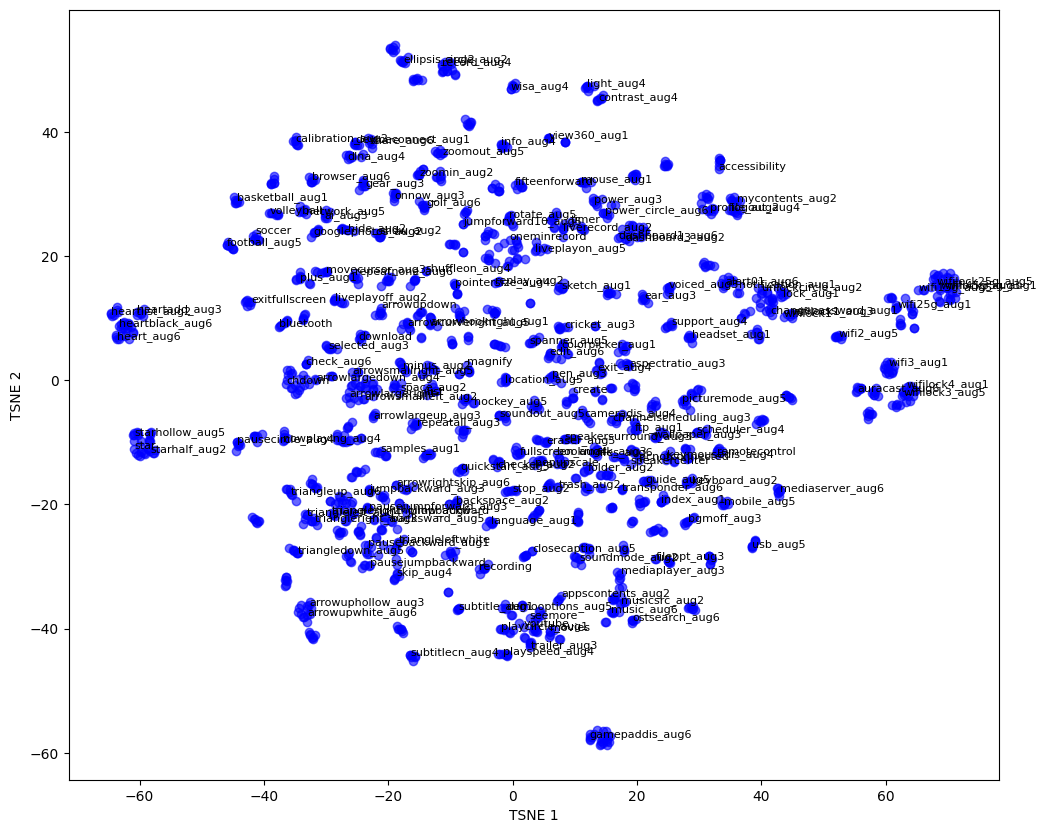

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# (이전 코드에서 레퍼런스 벡터와 라벨 생성 후)

# 7) 벡터 차원 축소 (TSNE)
print("TSNE로 벡터 차원 축소 중... (시간 좀 걸림)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
vectors_2d = tsne.fit_transform(reference_vectors)
# 8) 시각화
plt.figure(figsize=(12, 10))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='blue', alpha=0.6)

# 레이블 중 몇 개만 텍스트 표시 (너무 많으면 보기 어려움)
for i, label in enumerate(reference_labels):
    if i % 10 == 0:  # 20개마다 한 개씩 라벨 표시
        plt.text(vectors_2d[i, 0], vectors_2d[i, 1], label, fontsize=8)

# plt.title("레퍼런스 이미지 임베딩 TSNE 시각화")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

### 전처리 후 검색

In [15]:
import numpy as np
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
import cv2

# 1) CLIP 모델 로드
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model_name = "openai/clip-vit-base-patch32"
# model = CLIPModel.from_pretrained(model_name).to(device)
# processor = CLIPProcessor.from_pretrained(model_name)

# 2) 레퍼런스 벡터 불러오기
data = np.load(rf"..\vectorweight_최종.npz", allow_pickle=True)
reference_vectors = data["vectors"]
reference_labels = data["labels"]

print(f"레퍼런스 벡터 개수: {len(reference_labels)}개")

# 3) 검색용 쿼리 이미지 전처리 함수 (DB 생성과 동일)
def preprocess_icon_image(pil_image, size=(224,224), pad_color=255):
    img = np.array(pil_image.convert("L"))  # 흑백 변환
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)  # 이진화
    kernel = np.ones((3,3), np.uint8)
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)  # 노이즈 제거
    h, w = clean.shape
    scale = min(size[0]/h, size[1]/w)
    nh, nw = int(h*scale), int(w*scale)
    resized = cv2.resize(clean, (nw, nh))
    top = (size[0] - nh) // 2
    bottom = size[0] - nh - top
    left = (size[1] - nw) // 2
    right = size[1] - nw - left
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_color)
    pil_processed = Image.fromarray(padded).convert("RGB")
    return pil_processed

# 4) 쿼리 이미지 임베딩 생성 함수 (전처리 포함)
def extract_image_features(image_path):
    image = Image.open(image_path)

    #전처리
    processed_image = preprocess_icon_image(image)  # 전처리 추가
    inputs = processor(images=processed_image, return_tensors="pt").to(device)
    
    #전처리없음
    # inputs = processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        features = model.get_image_features(**inputs)
    features = features.cpu().numpy()
    features = features / np.linalg.norm(features)  # L2 정규화
    return features[0]

# 5) 쿼리 이미지 경로 지정
query_image_path = rf"../test5.png"  # 원하는 이미지 경로로 수정

# 6) 쿼리 이미지 임베딩 추출
query_vector = extract_image_features(query_image_path).reshape(1, -1)

# 7) 유사도 계산
similarities = cosine_similarity(query_vector, reference_vectors)[0]

# 상위 20개 결과 추출
top_k = 20
top_indices = similarities.argsort()[::-1]

unique_results = []
seen_base_names = set()

for idx in top_indices:
    label = reference_labels[idx]
    # '_aug' 이전까지를 원본명으로 사용
    if "_aug" in label:
        base_name = label.split("_aug")[0]
    else:
        base_name = label

    if base_name not in seen_base_names:
        seen_base_names.add(base_name)
        unique_results.append((base_name, similarities[idx]))  # base_name으로 저장

    if len(unique_results) >= top_k:
        break

print("\n[중복 제거 + 접미사 정리된 검색 결과 상위 20개]")
for rank, (base_name, score) in enumerate(unique_results, 1):
    print(f"{rank:2d}. 레퍼런스: {base_name:<30} 유사도: {score:.4f}")


레퍼런스 벡터 개수: 1778개

[중복 제거 + 접미사 정리된 검색 결과 상위 20개]
 1. 레퍼런스: nowplaying                     유사도: 0.7756
 2. 레퍼런스: ai                             유사도: 0.7698
 3. 레퍼런스: wisa                           유사도: 0.7624
 4. 레퍼런스: pause                          유사도: 0.7598
 5. 레퍼런스: move                           유사도: 0.7597
 6. 레퍼런스: refresh                        유사도: 0.7576
 7. 레퍼런스: googlephotos                   유사도: 0.7565
 8. 레퍼런스: jumpforward                    유사도: 0.7539
 9. 레퍼런스: network                        유사도: 0.7535
10. 레퍼런스: baseball                       유사도: 0.7501
11. 레퍼런스: newfeature                     유사도: 0.7498
12. 레퍼런스: input                          유사도: 0.7492
13. 레퍼런스: oneminrecord                   유사도: 0.7470
14. 레퍼런스: arrowhookright                 유사도: 0.7468
15. 레퍼런스: shuffle                        유사도: 0.7462
16. 레퍼런스: googledrive                    유사도: 0.7438
17. 레퍼런스: wifi15g                        유사도: 0.7429
18. 레퍼런스: backsward                      유사도: 0.7

In [32]:
unique_results

[('zoom_out', np.float32(0.7594495)),
 ('magnify', np.float32(0.7498183)),
 ('power', np.float32(0.7473268)),
 ('pointerspeed', np.float32(0.74710137)),
 ('onnow', np.float32(0.74556875)),
 ('closedcaption', np.float32(0.7431519)),
 ('now_playing', np.float32(0.74312675)),
 ('shopping', np.float32(0.7397243)),
 ('oneminplay', np.float32(0.7397216)),
 ('edit', np.float32(0.7386599)),
 ('demo_options', np.float32(0.7380721)),
 ('speaker_surround', np.float32(0.73703426)),
 ('trailer', np.float32(0.7369806)),
 ('spanner', np.float32(0.73677874)),
 ('download', np.float32(0.73645675)),
 ('skip', np.float32(0.73625666)),
 ('refresh', np.float32(0.7358452)),
 ('arrow_curve_right', np.float32(0.73511654)),
 ('uni2420', np.float32(0.73461485)),
 ('new_feature', np.float32(0.7344767))]